In [5]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 10.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 17.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 610.6/610.6 kB 12.8 MB/s eta 0:00:0000:01


In [19]:
#################### Importing libraries
import pandas as pd
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 15

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import pickle
import optuna

import warnings
warnings.filterwarnings("ignore")

import mplcatppuccin
import matplotlib as mpl
mpl.style.use(["ggplot", "mocha"])

In [7]:
# The directory for top level folder
dir_ = "/home/sugam/Work/20-29 Deep Learning/22 Projects/Optimization of Energy Using AIML"

processed_data_dir = dir_+'/data/Processed/'
model_dir = dir_+'/models/'
report_dir = dir_ + "/reports/figures/"

In [8]:
target_columns = "load"

In [9]:
# Load your dataset
train_data =  pd.read_csv(processed_data_dir + "train.csv")
validation_data =  pd.read_csv(processed_data_dir + "validation.csv")
test_data =  pd.read_csv(processed_data_dir + "test.csv")

In [10]:
print(f"Size of training data {train_data.shape}")
print(f"Size of validation data {validation_data.shape}")
print(f"Size of testing data {test_data.shape}")

Size of training data (82437, 51)
Size of validation data (10305, 51)
Size of testing data (10305, 51)


In [11]:
train_data = pd.concat([train_data,validation_data],axis=0)
del validation_data

In [13]:
X_train, y_train = train_data.drop(target_columns, axis=1), train_data[target_columns]
X_test, y_test = test_data.drop(target_columns, axis=1), test_data[target_columns]

In [14]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

print(f"Shape of Train data: {X_train_scaled.shape}")
print(f"Shape of Test data: {X_test_scaled.shape}")

Shape of Train data: (92742, 50)
Shape of Test data: (10305, 50)


In [15]:
################### BASE Random Forest model
random.seed(1234)
rf_model = RandomForestRegressor(n_jobs=-1,
                                verbose=1)
rf_model.fit(X_train_scaled, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomForestRegressor(n_jobs=-1, verbose=1)

In [16]:
model_name = model_dir+'rf_base.bin'
pickle.dump(rf_model, open(model_name, 'wb'))

In [17]:
with open(model_name, 'rb') as file:  
    rf_base = pickle.load(file)

In [20]:
rf_predictions_test = rf_base.predict(X_test_scaled)
rf_predictions_train = rf_base.predict(X_train_scaled)

# Calculate RMSE for Random Forest
rf_rmse_train = np.sqrt(mean_squared_error(y_train, rf_predictions_train))
print("Random Forest RMSE for Train data :", rf_rmse_train)

rf_rmse_test = np.sqrt(mean_squared_error(y_test, rf_predictions_test))
print("Random Forest RMSE for Test data :", rf_rmse_test)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s


Random Forest RMSE for Train data : 0.7513268787600841
Random Forest RMSE for Test data : 2.320969012501151


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


In [ ]:
# ####################################################### Parameter Optimization
# #-------------------------------------------------DO NOT RUN THIS--------------------------------------
# def objective(trial):
#     criterion = trial.suggest_categorical("criterion",["squared_error", "absolute_error", "friedman_mse", "poisson"])
#     max_depth = trial.suggest_int("max_depth",2,32)
#     min_samples_split = trial.suggest_int("min_samples_split",2,10)
#     min_samples_leaf = trial.suggest_int("min_samples_leaf",1,10)
#     n_estimators = trial.suggest_int("n_estimators",100,500)
#     max_features = trial.suggest_int("max_features",1,10)

    
#     rf_model = RandomForestRegressor(criterion = criterion,
#                                       max_depth = max_depth,
#                                       min_samples_split = min_samples_split,
#                                       min_samples_leaf = min_samples_leaf,
#                                       n_estimators = n_estimators,
#                                       max_features = max_features,
#                                       n_jobs=-1,
#                                       verbose = 2,
#                                       random_state = 0,
#                                       oob_score = True # CV of random forest
#                                      )
    
#     rf_model.fit(X_train_scaled,y_train)
#     rmse_score = mean_squared_error(y_train,
#                                     rf_model.predict(X_train_scaled),
#                                     squared=False)
#     return rmse_score

# with tf.device('/gpu:0'): 
#     study = optuna.create_study(direction="minimize",
#                                 study_name="random_forest_study")
#     study.optimize(objective, n_trials=5)
# trial = study.best_trial
# print(f"RMSE: {trial.value}")
# print(f"Params: {trial.params}")

In [21]:
###################################----->Final Model<------------------------
random.seed(1234)
rf_model = RandomForestRegressor(criterion = 'friedman_mse',
                                 max_depth = 17,
                                 min_samples_split = 8,
                                 min_samples_leaf = 3,
                                 n_estimators = 415,
                                 max_features = 5,
                                 n_jobs=-1,
                                 verbose=1)

rf_model.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 415 out of 415 | elapsed:   21.9s finished


RandomForestRegressor(criterion='friedman_mse', max_depth=17, max_features=5,
                      min_samples_leaf=3, min_samples_split=8, n_estimators=415,
                      n_jobs=-1, verbose=1)

In [22]:
model_name = model_dir+'rf_final.bin'
pickle.dump(rf_model, open(model_name, 'wb'))

In [23]:
with open(model_name, 'rb') as file:  
    rf_final = pickle.load(file)

In [24]:

rf_predictions_training = rf_final.predict(X_train_scaled)
rf_predictions_testing = rf_final.predict(X_test_scaled)

rf_rmse_training = mean_squared_error(y_train, rf_predictions_training, squared=False)
rf_rmse_testing = mean_squared_error(y_test, rf_predictions_testing, squared=False)
print(f'Training RMSE: {rf_rmse_training}')
print(f'Testing RMSE: {rf_rmse_testing}')

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.6s


Training RMSE: 3.9201149482637185
Testing RMSE: 3.372830058938184


[Parallel(n_jobs=12)]: Done 415 out of 415 | elapsed:    1.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 415 out of 415 | elapsed:    0.1s finished


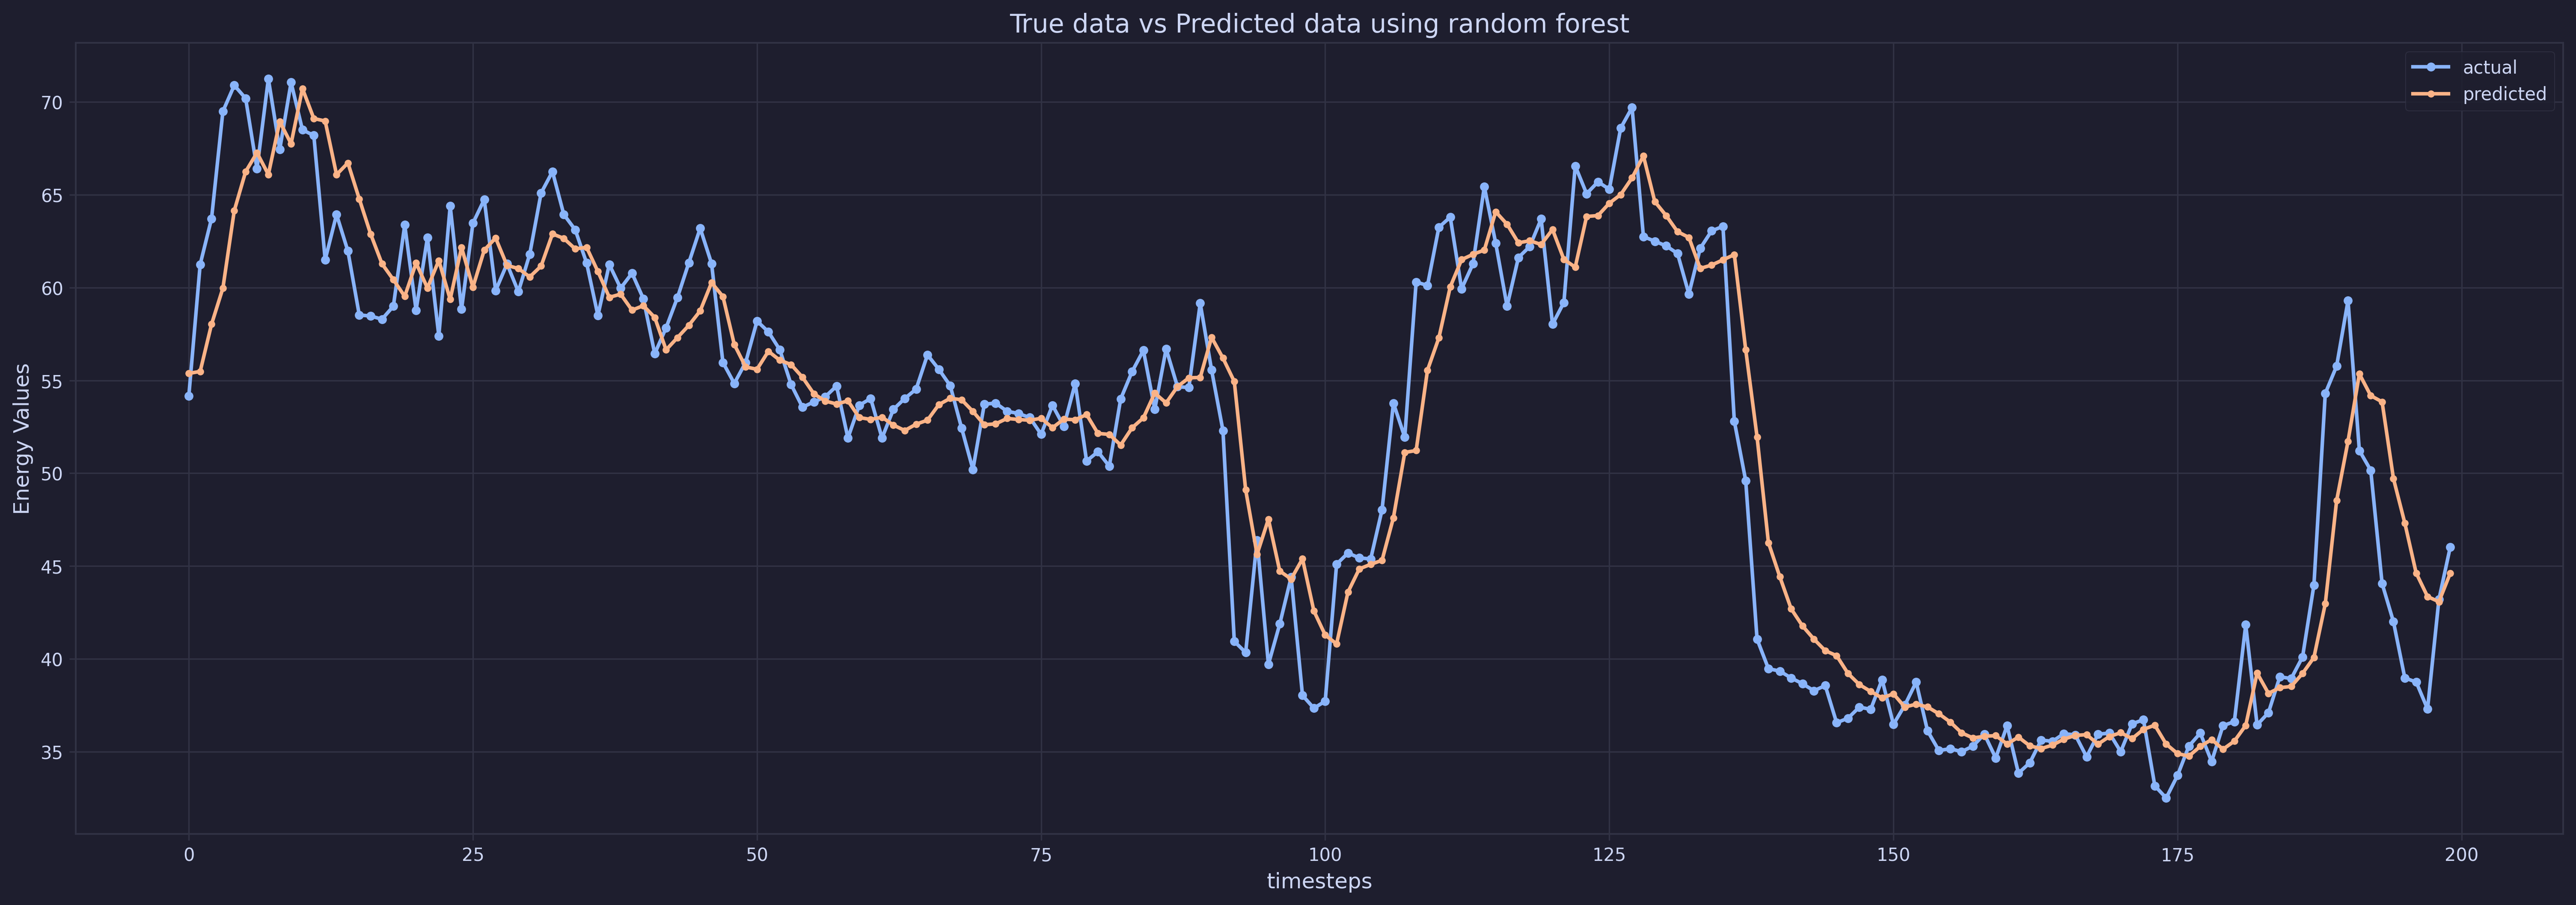

In [26]:
fig = plt.figure()
plt.plot(y_test.values[:200], linewidth=2, marker = 'o', ms=4)
plt.plot(rf_predictions_testing[:200], linewidth=2, marker = 'o', ms=3)
plt.legend(["actual","predicted"])
plt.title("True data vs Predicted data using random forest")
plt.xlabel("timesteps")
plt.ylabel("Energy Values")

plt.savefig(report_dir + "random_forest_test_line_graph.jpg", 
            dpi=500,
            format=None,
            transparent=False,
            bbox_inches=None, 
            pad_inches=0.1)